# Predicting Stock Market Trends

## Correlating BBC News Sentiments with S&P 500 Stock Movements

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import kagglehub as kh
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input, Dropout, Embedding, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

## Loading the data

In [4]:
ticker = '^GSPC'
start_date = '2023-01-01'
end_date = '2024-12-31'
stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data = stock_data.reset_index()
stock_data.head(2)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
0,2023-01-03,3824.139893,3878.459961,3794.330078,3853.290039,3959140000
1,2023-01-04,3852.969971,3873.159912,3815.770020,3840.360107,4414080000


In [5]:
stock_data.columns = [col[0] for col in stock_data.columns] # renaming columns
stock_data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [6]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    501 non-null    datetime64[ns]
 1   Close   501 non-null    float64       
 2   High    501 non-null    float64       
 3   Low     501 non-null    float64       
 4   Open    501 non-null    float64       
 5   Volume  501 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 23.6 KB


No null values which is good.

In [7]:
stock_data['Date'] = stock_data['Date'].dt.date # converts the 'Date' column to the date as a string
stock_data.head(2)

,Date,Close,High,Low,Open,Volume
0,2023-01-03,3824.139893,3878.459961,3794.330078,3853.290039,3959140000
1,2023-01-04,3852.969971,3873.159912,3815.770020,3840.360107,4414080000


In [8]:
# Set the path to the file you'd like to load
file_path = "bbc_news.csv"

# Load the latest version
news_data = kh.load_dataset( # loads the news data using kagglehub
  kh.KaggleDatasetAdapter.PANDAS,
  "gpreda/bbc-news",
  file_path
)
news_data.head(2)

<ipython-input-8-4931ee518df5>:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  news_data = kh.load_dataset( # loads the news data using kagglehub


100%|██████████| 12.9M/12.9M [00:00<00:00, 154MB/s]


,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."


In [9]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42115 entries, 0 to 42114
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        42115 non-null  object
 1   pubDate      42115 non-null  object
 2   guid         42115 non-null  object
 3   link         42115 non-null  object
 4   description  42115 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


Also no null values which is perfect!

In [10]:
news_data['pubDate'] = pd.to_datetime(news_data['pubDate'], utc=True) # converts the 'pubDate' column to datetime objects
news_data = news_data.set_index('pubDate').sort_index().loc['2023-01-01':'2024-12-31'].reset_index() # filters the news data by date
news_data['pubDate'] = news_data['pubDate'].dt.date # converts the 'pubDate' column to a date as a string
news_data.head(2)

,pubDate,title,guid,link,description
0,2023-01-01,Match of the Day analysis: Marcus Rashford shi...,https://www.bbc.co.uk/sport/av/football/64137805,https://www.bbc.co.uk/sport/av/football/641378...,Match of the Day pundits Alan Shearer and Dann...
1,2023-01-01,Archbishop of Canterbury calls for leaders to ...,https://www.bbc.co.uk/news/uk-64137439,https://www.bbc.co.uk/news/uk-64137439?at_medi...,The Most Reverend Justin Welby uses his new ye...


## EDA

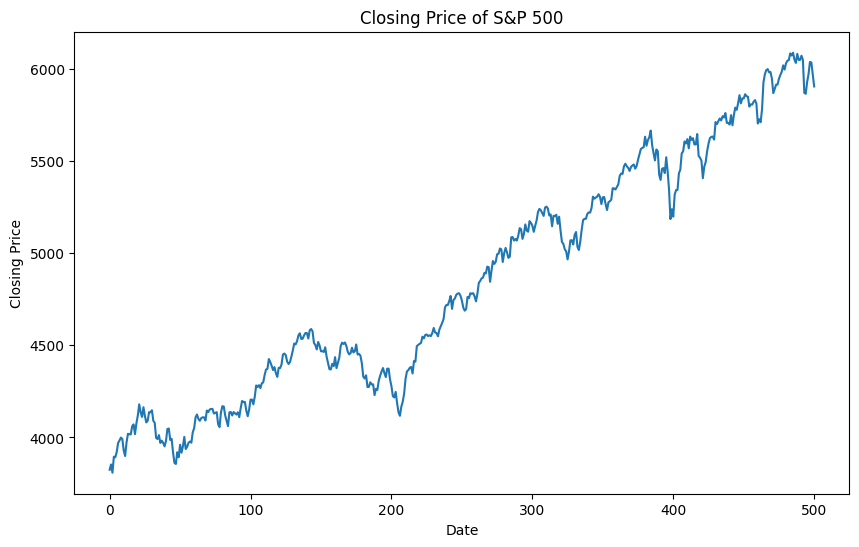

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'])
plt.title('Closing Price of S&P 500')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

The stock price can be viewed as a function of time with the X-axis represented in days and the Y-axis representing the stock price in dollars.
We can already see the positive trend.

---

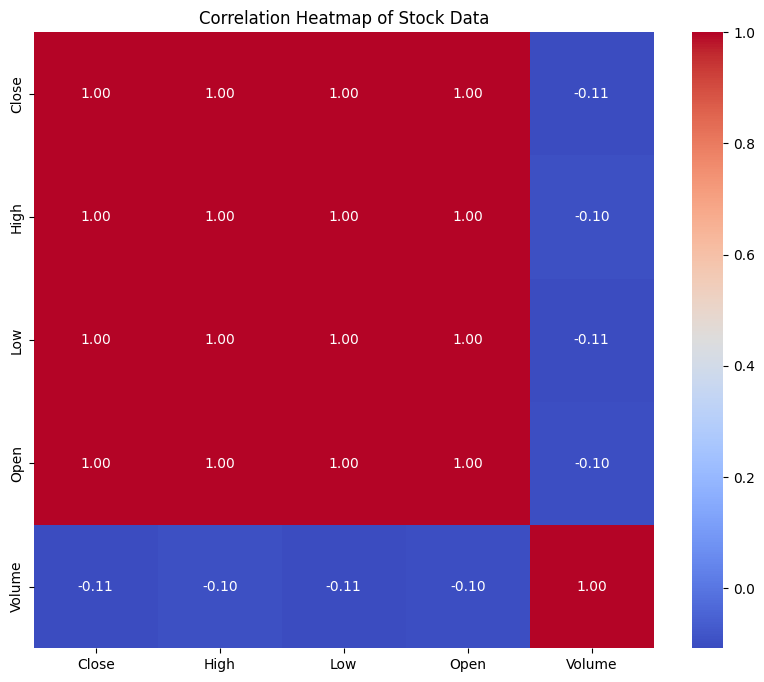

In [12]:
correlations = stock_data.drop(['Date'], axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Stock Data')
plt.show()

In the heat map, the correlation matrix between the numerical variables is displayed

A value of 0 indicates no relationship, a value of 1 shows a perfect positive relationship characterized by diagonals that represent the relationship of a variable with itself

Using the **coolwarm** color palette displays the levels of relationships between the variables.

Warm colors (red) indicate a high positive correlation, while cold colors (blue) indicate a negative correlation.


For example, there is a 10 percent negative relationship between the highest price and the trading volume (number of transactions) on that day and the conclusion is that there is probably no direct relationship between them. Which sounds logical.

You can also see a perfect positive relationship between all prices, which makes sense because it is the same price that changes.

---

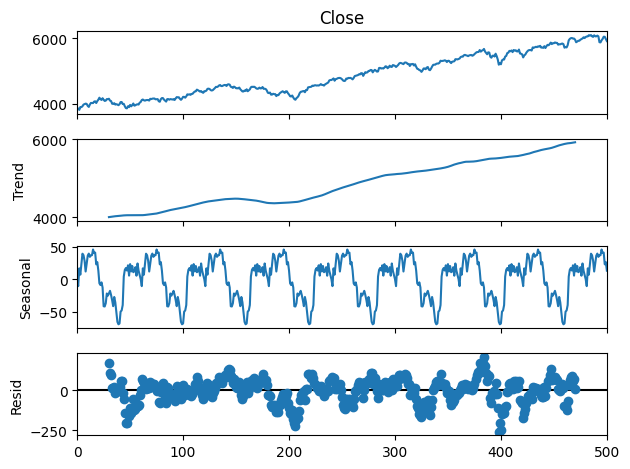

In [13]:
seasonal_decompose(stock_data['Close'], model='additive', period=60).plot()
plt.show()

This plot shows the seasonal decomposition of the S&P 500 closing price. It breaks down the time series into its trend, seasonal, and residual components.


*   Trend: Shows the overall long-term movement of the series.
*   Seasonal: Shows the repeating patterns or cycles in the series.
*   Residual: Shows the remaining variation that is not explained by the trend or seasonality. By looking at this plot, you can understand the underlying patterns in the stock price and identify any seasonality or trends.

For example, this plot shows an upward trend in the stock price over time.

---

In [14]:
# Adding Year and Month Columns
news_data['year'] = pd.to_datetime(news_data['pubDate']).dt.year
news_data['month'] = pd.to_datetime(news_data['pubDate']).dt.month

In [15]:
# Monthly Articles Count
monthly_articles_counts = news_data.groupby(['year', 'month']).size().reset_index(name='counts')

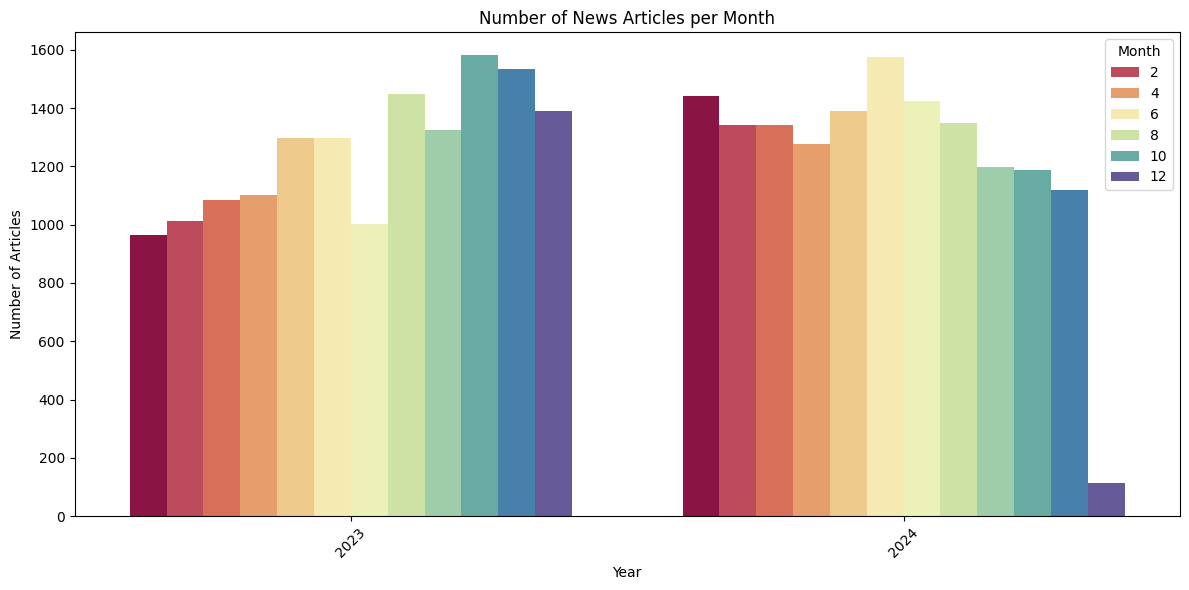

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='counts', hue='month', data=monthly_articles_counts, palette='Spectral')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('Number of News Articles per Month')
plt.xticks(rotation=45)
plt.legend(title='Month')
plt.tight_layout()
plt.show()

This plot shows the number of news articles published per month.


*   X-axis: Represents the year.
*   Y-axis: Represents the number of articles
*   Bars: Represent different months within each year. You can see how the volume of news articles varies over time and whether there are any noticeable patterns or trends. For example, we can see that December 2024 doesn't have as much articles as every other month in this 2 year period, so I decided to drop that month so the time-series model won't "jump" from date to date.

---

In [17]:
# Filtering Stock Data
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.set_index('Date').loc[:'2024-11-30'].reset_index()
stock_data['Date'] = stock_data['Date'].dt.date

In [18]:
# Filtering News Data
news_data['pubDate'] = pd.to_datetime(news_data['pubDate'])
news_data = news_data.set_index('pubDate').loc[:'2024-11-30'].reset_index() # Include data up to November 30
news_data['pubDate'] = news_data['pubDate'].dt.date

In [19]:
# Selecting Relevant Columns
news_data = news_data[['pubDate', 'title']]
news_data.head(3)

,pubDate,title
0,2023-01-01,Match of the Day analysis: Marcus Rashford shi...
1,2023-01-01,Archbishop of Canterbury calls for leaders to ...
2,2023-01-01,How a secret message in a Colombian song gave ...


In [20]:
# Initializing variables for text preprocessing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

Defining a function called `clean_text` that performs text cleaning and preprocessing. It tokenizes the input text, converts it to lowercase, removes stop words and non-alphanumeric words, lemmatizes the remaining words, and joins them back into a string.

In [21]:
def clean_text(text):
    words = word_tokenize(str(text).lower())
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word.isalnum() and word not in stop_words
    ]
    return " ".join(words)

In [22]:
news_data["cleaned_title"] = news_data["title"].fillna("").apply(clean_text) # Applies the clean_text function to the 'title' column.
news_data.head(2)

,pubDate,title,cleaned_title
0,2023-01-01,Match of the Day analysis: Marcus Rashford shi...,match day analysis marcus rashford shine manch...
1,2023-01-01,Archbishop of Canterbury calls for leaders to ...,archbishop canterbury call leader fix social care


 Initializing a tokenizer and fitting it on the cleaned news titles. The tokenizer converts the text into numerical sequences that can be used as input for machine learning models.

In [23]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") # Initializing a tokenizer with a vocabulary size of 5000 and an out-of-vocabulary token.
tokenizer.fit_on_texts(news_data["cleaned_title"]) # Fitting the tokenizer on the cleaned titles.
sequences = tokenizer.texts_to_sequences(news_data["cleaned_title"]) # Converting the cleaned titles into sequences of numerical tokens.

In [24]:
sorted([len(seq) for seq in sequences], reverse=True)[:10] # The lengths of the 10 longest cleaned titles

[18, 18, 17, 17, 16, 16, 16, 16, 16, 16]

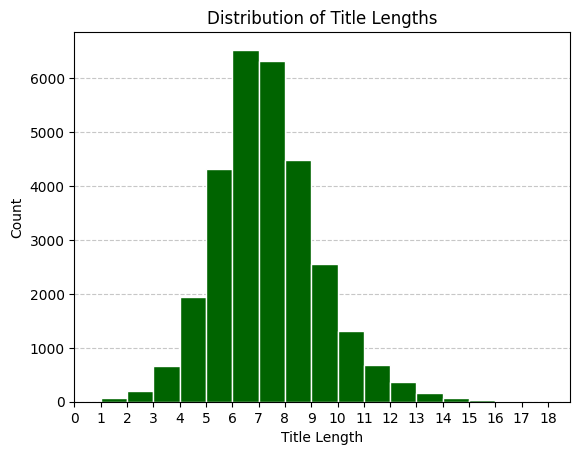

In [25]:
sequence_lengths = [len(seq) for seq in sequences] # Calculates the length of each sequence.
plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 1), edgecolor='w', color='darkgreen', zorder=2)
plt.xticks(np.arange(0, max(sequence_lengths)+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Title Length")
plt.ylabel("Count")
plt.title("Distribution of Title Lengths")
plt.show()


A histogram showing the distribution of title lengths in the news data. The histogram helps to visualize the frequency of different title lengths. We can see how the titles lengths are normally distributed, which makes sense because those titles are made by people.
we can also see how most of the titles having 7 or 8 words in them.
Will be helpfull for when we will pad the sequnces.

---
Printing the top 50 most frequent words to go over them and

In [26]:
# Displays the top 50 most frequent words.
sorted_word_counts = dict(sorted(tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True))
print(list(sorted_word_counts)[:50])

['say', 'england', 'uk', 'win', 'new', 'woman', 'world', 'u', 'man', '2023', 'cup', 'police', 'ukraine', 'war', 'year', 'gaza', 'first', 'day', 'attack', 'election', 'strike', 'trump', 'bbc', 'watch', 'israel', 'death', 'city', 'dy', 'league', 'show', 'paper', 'could', 'star', 'child', 'home', 'final', 'family', 'get', 'two', 'killed', 'hit', 'beat', 'king', '2024', 'labour', 'back', 'sunak', 'found', 'russia', 'life']


In [27]:
def clean_text(text):
    words = word_tokenize(str(text).lower())
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word.isalnum() and word not in stop_words
    ]
        # Explicitly remove 'u', 'dy', and '2023'
    words = [word for word in words if word not in ['u', 'dy', '2023']]
    return " ".join(words)

In [28]:
# Reapplying the updated clean_text function, refitting the tokenizer, and recalculating the sorted word counts.
news_data["cleaned_title"] = news_data["title"].fillna("").apply(clean_text)
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(news_data["cleaned_title"])
sequences = tokenizer.texts_to_sequences(news_data["cleaned_title"])
sorted_word_counts = dict(sorted(tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True))

In [29]:
print(list(sorted_word_counts)[:30]) # Checks if they got removed.

['say', 'england', 'uk', 'win', 'new', 'woman', 'world', 'man', 'cup', 'police', 'ukraine', 'war', 'year', 'gaza', 'first', 'day', 'attack', 'election', 'strike', 'trump', 'bbc', 'watch', 'israel', 'death', 'city', 'league', 'show', 'paper', 'could', 'star']


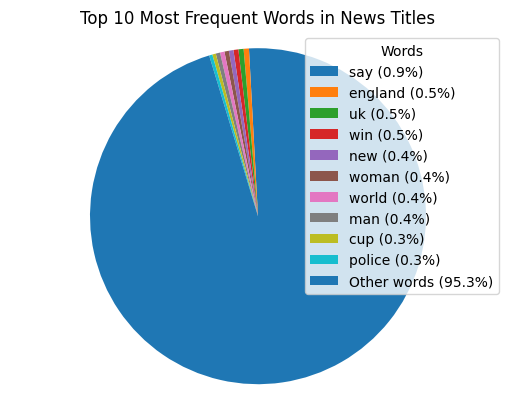

In [30]:
top_10_words = dict(list(sorted_word_counts.items())[:10]) # Selects the top 10 most frequent words.
other_words_count = sum(sorted_word_counts.values()) - sum(top_10_words.values()) # Calculates the count of all other words.

# Creates labels and sizes for the pie chart.
labels = list(top_10_words.keys()) + ['Other words']
sizes = list(top_10_words.values()) + [other_words_count]

# Calculate percentages
total_count = sum(sizes)
percentages = [(count / total_count) * 100 for count in sizes]

# Create legend labels with percentages
labels_with_percentages = [f"{label} ({percentage:.1f}%)" for label, percentage in zip(labels, percentages)]

plt.pie(sizes, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Top 10 Most Frequent Words in News Titles")
plt.legend(labels_with_percentages, title="Words", loc="best")
plt.show()

The pie chart visualizes the relative frequency of the top 10 most frequent words in the dataset.

---

In [31]:
# Calculating the change in closing price from the previous day
stock_data['change'] = stock_data['Close'].shift(1) - stock_data['Close']
stock_data.head(2)

,Date,Close,High,Low,Open,Volume,change
0,2023-01-03,3824.139893,3878.459961,3794.330078,3853.290039,3959140000,NaN
1,2023-01-04,3852.969971,3873.159912,3815.770020,3840.360107,4414080000,-28.830078


In [32]:
# Changing for the first day to 0, as there is no previous day's data to calculate the change from.
stock_data.loc[stock_data.index[0], 'change'] = 0
stock_data.head(2)

,Date,Close,High,Low,Open,Volume,change
0,2023-01-03,3824.139893,3878.459961,3794.330078,3853.290039,3959140000,0.000000
1,2023-01-04,3852.969971,3873.159912,3815.770020,3840.360107,4414080000,-28.830078


Creating a new column called `shift_label` to represent the direction of the price change. It assigns 1 for a positive change, -1 for a negative change, and 0 for no change. The first row is dropped since it has a 0 value due to the initialization, and it's the only 0 value in the dataset.

In [33]:
stock_data['shift_label'] = 0
stock_data.loc[stock_data['change'] > 0, 'shift_label'] = 1
stock_data.loc[stock_data['change'] < 0, 'shift_label'] = -1
stock_data = stock_data.drop(0)
stock_data.head(2)

,Date,Close,High,Low,Open,Volume,change,shift_label
1,2023-01-04,3852.969971,3873.159912,3815.770020,3840.360107,4414080000,-28.830078,-1
2,2023-01-05,3808.100098,3839.739990,3802.419922,3839.739990,3893450000,44.869873,1


##  Predicting trends using a classic model

In [34]:
features = ['Open', 'High', 'Low', 'Close', 'Volume'] # Defines the features to be used for prediction.
X = stock_data[features] # Selects the features from the stock data.
y = stock_data['shift_label'] # Selects the target variable

Feature scaling is often necessary to ensure that features with different ranges do not unduly influence the model. Also so the model will handle smaller numbers.

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
# Splits the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Remapping the target variable values for the XGBoost model. It changes -1 to 0 to fit the requirements of the XGBoost classifier.

In [37]:
y_train_remapped = np.where(y_train == -1, 0, y_train)
y_test_remapped = np.where(y_test == -1, 0, y_test)

In [38]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        # Regularization parameter, smaller value → stronger regularization
    'penalty': ['l1', 'l2'],             # Check both L1 and L2 penalties
    'solver': ['liblinear']            # liblinear supports binary problems with L1 and L2
}

# grid_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1', n_jobs=-1)
# grid_lr.fit(X_train, y_train)

param_grid_rf = {
    'n_estimators': [100, 200, 300], # The number of decision trees in the forest
    'max_depth': [None, 10, 20, 30], # The maximum depth of each decision tree.
    'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node.
    'min_samples_leaf': [1, 2, 4], # The minimum number of samples required to be at a leaf node.
    'max_features': ['sqrt', 'log2', None] # The number of features to consider when looking for the best split.
}

# grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='f1_macro')
# grid_rf.fit(X_train, y_train)

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3], # The step size shrinkage used in update to prevents overfitting.
    'subsample': [0.6, 0.8, 1.0], # The fraction of samples to be used for fitting the individual base learners.
    'colsample_bytree': [0.6, 0.8, 1.0], #  Denotes the fraction of columns to be randomly samples for each tree.
    'gamma': [0, 0.1, 0.3, 0.5] # Minimum loss reduction required to make a further partition on a leaf node of the tree.
}

# xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
# grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
# grid_xgb.fit(X_train, y_train_remapped)

In [39]:
# print("Best parameters for Logistic Regression:", grid_lr.best_params_)
# print("Best parameters for Random Forest:", grid_rf.best_params_)
# print("Best parameters for XGBoost:", grid_xgb.best_params_)

Best parameters for Logistic Regression:

`{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}`

Best parameters for Random Forest:

`{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}`

Best parameters for XGBoost:

`{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}`


In [40]:
models = {'Logistic Regression': LogisticRegression(C=10, penalty='l1', solver='liblinear'),
          'Random Forest': RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100),
          'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42, colsample_bytree= 1.0, gamma= 0, learning_rate= 0.2, max_depth= 5, n_estimators= 2)}

print(f"{'-'*5} Model Test Evaluation: {'-'*5}")
for name, model in models.items():
  model.fit(X_train, y_train_remapped)
  y_pred = model.predict(X_test)
  print(f"{name} Accuracy:", accuracy_score(y_test_remapped, y_pred))
  print(f"{name} F1-Score:", f1_score(y_test_remapped, y_pred, average='macro'))
print()
print(f"{'-'*5} Model Train Evaluation: {'-'*5}")
for name, model in models.items():
  model.fit(X_train, y_train_remapped)
  y_pred = model.predict(X_train)
  print(f"{name} Accuracy:", accuracy_score(y_train_remapped, y_pred))
  print(f"{name} F1-Score:", f1_score(y_train_remapped, y_pred, average='macro'))

----- Model Test Evaluation: -----
Logistic Regression Accuracy: 0.84375
Logistic Regression F1-Score: 0.8437330439500814
Random Forest Accuracy: 0.5416666666666666
Random Forest F1-Score: 0.5366388767003072
XGBoost Accuracy: 0.5625
XGBoost F1-Score: 0.48121461657231085

----- Model Train Evaluation: -----
Logistic Regression Accuracy: 0.8307291666666666
Logistic Regression F1-Score: 0.8228468008091132
Random Forest Accuracy: 1.0
Random Forest F1-Score: 1.0
XGBoost Accuracy: 0.6510416666666666
XGBoost F1-Score: 0.5246646713224699




*   Accuracy: Overall correctness of the model.
*   F1 Score: Balance between precision (correctly identified positives) and recall (correctly identified positives out of all actual positives).



    
    

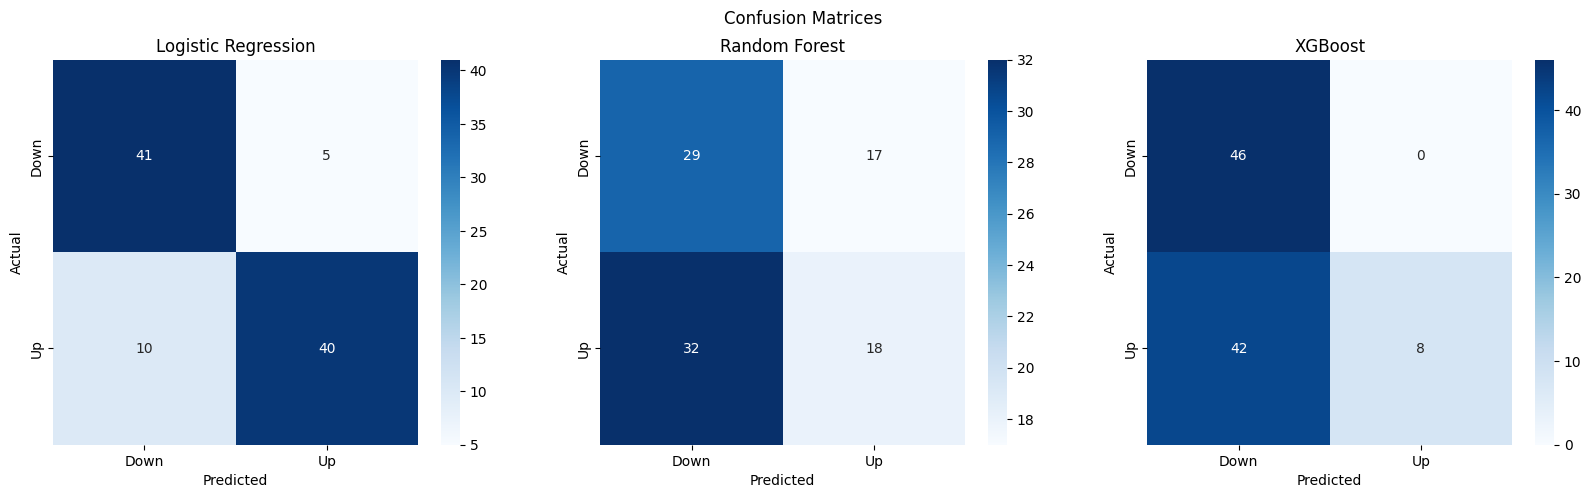

In [41]:
# הגדרה של שתי גרפים
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
labels = ['Down', 'Up']
plt.suptitle('Confusion Matrices')
# מעבר על כל מודל
for i, model in enumerate(models.items()):
    # התאמה של כל מודל לגרף הנכון
    plt.sca(ax[i])
    # יצירת משתנה של מטריצת בלבול שתראה לי איפה המודל חזה נכון ולהפך
    cm = confusion_matrix(y_test_remapped, model[1].predict(X_test))
    # מפת חום להצגה נוחה של המטריצה והגדרתה (שמות כותרות לצירים, כותרת, מפת צבעים...)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(model[0])
plt.show()

The Confusion matrix shows the number of correct and incorrect classifications for each category.

For each model tested, its error matrix is ​​shown.

The x-axis represents the categories classified by the model and the y-axis represents the true categories.

Each cell in the matrix shows the number of examples classified as a particular category.

Cells on the diagonal represent correct classifications, while cells off the diagonal represent incorrect classifications.

It can be seen that there are more errors in the Decision-Tree based models than the Logistic regression.

---
(So the logisic regression won if I wasnt clear enough)

---

## Time Series Model using LSTM

In [42]:
close_prices = stock_data['Close'].values.reshape(-1, 1) # Reshapes the closing prices into a 2D array.
scaler_ts = StandardScaler()
scaled_close = scaler_ts.fit_transform(close_prices)

Implementing the "Sliding Window" technique to split the data into 2 month timeframes of closing prices and the next day's closing price as the target value.

In [43]:
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

Creating the 2 month sequences than reshaping the data into a (samples, timesteps, features) format as the LSTM model expects.

In [44]:
window_size = 60
X_lstm, y_lstm = create_dataset(scaled_close, window_size)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)
X_lstm.shape

(420, 60, 1)

In [45]:
# # Splits the data into training and testing sets.
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [46]:
# verify their dimensions.
X_lstm_train.shape, y_lstm.shape

((336, 60, 1), (420, 1))

The callbacks include `EarlyStopping` to stop training if the validation loss doesn't improve for a certain number of epochs and `ReduceLROnPlateau` to reduce the learning rate if the validation loss plateaus.

In [47]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

The model consists of input, bidirectional LSTM, dropout, dense with ReLU activation funcion, and output layers. Bidirectional LSTMs process the input sequence in both forward and backward directions to capture information from past and future contexts. Dropout is used to prevent overfitting.

In [48]:
model_lstm = Sequential([
    Input(shape=(X_lstm_train.shape[1], 1)),
    Bidirectional(LSTM(50, return_sequences=True)),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(25, 'relu'),
    Dense(1)
])

Compiling using the Adam optimizer for weight updates, mean squared error as the loss function, and mean absolute error as a metric. The model is trained for 100 epochs with a batch size of 32. It also utilizes the callbacks defined earlier for early stopping and learning rate reduction.

In [ ]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = model_lstm.fit(
    X_lstm_train, y_lstm_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_lstm_test, y_lstm_test),
    callbacks=callbacks_list
)


In [50]:
lowest_val_loss = min(history.history['val_loss'])
print(f"Lowest Validation Loss: {lowest_val_loss}")

Lowest Validation Loss: 0.007622861303389072


In [51]:
lowest_close_price = np.sqrt(scaler_ts.inverse_transform([[lowest_val_loss]])[0][0])
print(f"Lowest Close Price: {lowest_close_price}")

Lowest Close Price: 69.38785462600137


The lowest validation loss is 0.00822, which translates to a lowest close price of approximately 69.412 dollars.

---

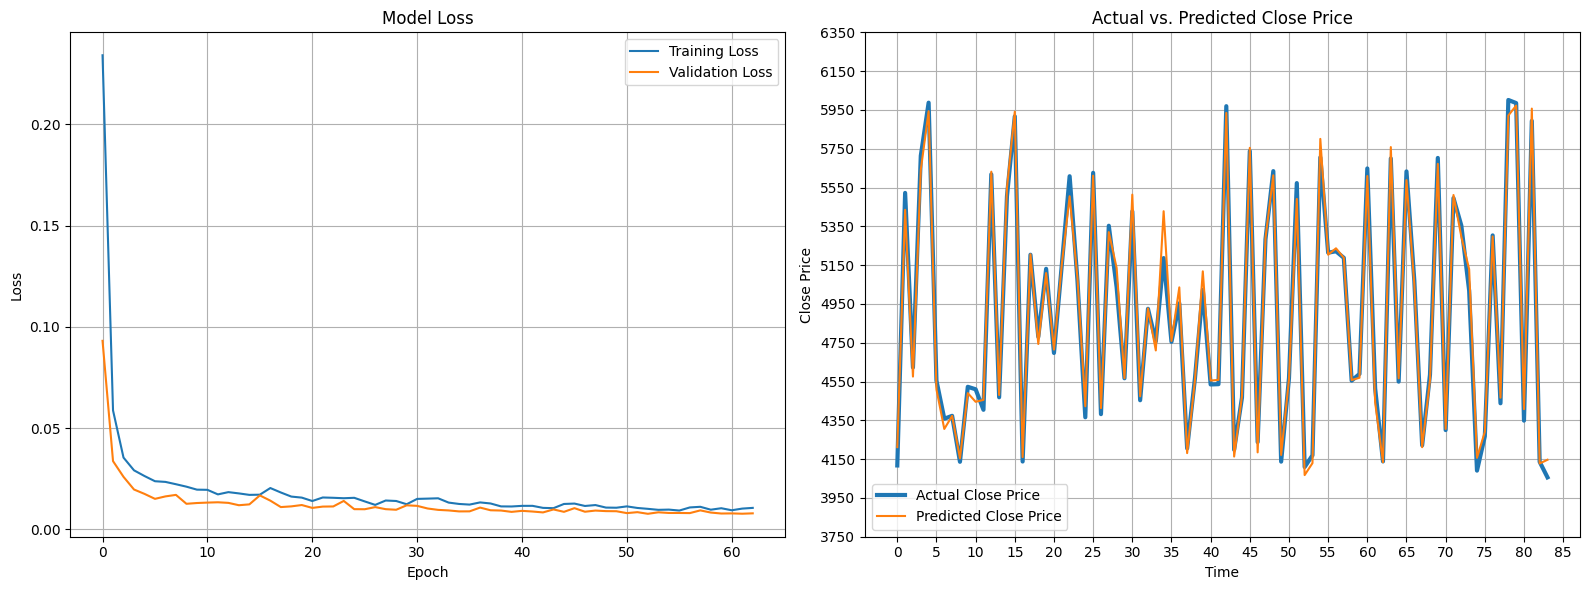

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot 1: Model Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)  # Add grid to the first subplot

# Invert scaling to get actual and predicted values on original scale
y_lstm_inv = scaler_ts.inverse_transform(y_lstm_test.reshape(-1, 1))  # Reshape y_lstm_test for inverse_transform
y_pred_lstm = model_lstm(X_lstm_test)
y_pred_lstm_inv = scaler_ts.inverse_transform(y_pred_lstm)

# Plot 2: Actual vs. Predicted Close Price
axes[1].plot(y_lstm_inv, label='Actual Close Price', linewidth=3)
axes[1].plot(y_pred_lstm_inv, label='Predicted Close Price')
axes[1].set_ylim(bottom=3750)
axes[1].set_yticks(np.arange(3750, 6500, 200))
axes[1].set_xticks(np.arange(0, 90, 5))
axes[1].set_title('Actual vs. Predicted Close Price')
axes[1].grid(True)  # Add grid to the second subplot
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Close Price')
axes[1].legend(loc='lower left')

plt.tight_layout()  # Adjust subplot params for a tight layout
plt.show()

We (I) created 2 plots:


1.   Model Loss: Shows the training and validation loss over epochs.
2.   Actual vs. Predicted Close Price: Compares the actual and predicted closing prices. It also inverts the scaling to display the values on the original scale.

The "model loss" plot, also known as the learning curve, is a visualization that shows the performance of a machine learning model during training. It typically displays the loss values (a measure of how well the model is performing)[The lower the better] on the y-axis and the number of training epochs (iterations over the training data) on the x-axis.

The "Actual vs. Predicted Close Price" plot allows us to visually assess the performance of our (my) model in predicting the closing prices of the S&P 500 index.

Ideally, you would want to see the predicted closing prices closely following the actual closing prices, indicating a good fit, which they seem to be.
We also know
Deviations between the two lines represent the prediction errors.

---
Pros of this kind of approach:

*   LSTMs are built to handle data in sequence. They can effectively learn how stock prices change over time.
*   LSTMs can learn non-linear relationships within the data, which are common in financial time series.
*   The model can be adapted to different timeframes (e.g., daily, weekly, monthly) by adjusting the input data and window size.

but some cons of this approach are:

*   LSTMs usually need lots of data to train in order to perform optimally. If there is not enough data, it leads to overfitting and bad generalization.
*   LSTMs are fairly complex models with a large number of parameters, which can make them computationally costly to train and optimize.
*   The performance of LSTMs depends greatly on hyperparameters such as the number of layers, units, and dropout rate. These need to be carefully fine-tuned by you to give the maximum.
*   LSTMs are "black box" models. This means it is hard to comprehend the reasons behind their predictions.
*   The model only looks at past price data and might not consider outside factors (like news stories and economic data) which have a strong influence on stock prices. (Which we'll try to fix later.)
*   Financial markets are unstable in nature, and the model may not be able to predict sudden and unexpected price movements.

---


## Sentiment Analysis based on News Titles

The USE model is a pre-trained model that can generate embeddings (numerical representations) of sentences.

In [53]:
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

BERT (Bidirectional Encoder Representations from Transformers) is another powerful pre-trained model for natural language processing. Sentence transformer models are specifically designed to generate embeddings that capture the semantic meaning of sentences, making them suitable for tasks like sentiment analysis and text similarity.

Don't get excited (spoiler: He didn't perform so well..)

In [ ]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

KMeans is an unsupervised learning algorithm that can group similar data points into clusters. It groups data points that are closer to each other into the same cluster (usually calculated using Euclidean distance), while data points that are farther apart are assigned to different clusters.
Here we've used 2 clusters

In [55]:
kmeans = KMeans(n_clusters=2, random_state=42)

Generating embeddings for the cleaned news titles using the USE model and then clusters those embeddings using KMeans, aiming to identify potential clusters of news titles based on their sentiment.

In [56]:
use_embeddings = use_model(news_data['cleaned_title'].tolist())
use_clusters = kmeans.fit_predict(use_embeddings)

In [57]:
pd.Series(use_clusters).value_counts() # Prints the number of data points in each cluster.

,count
0,23330
1,6360


Doing the same but with the BERT model.

In [58]:
bert_embeddings = bert_model.encode(news_data['cleaned_title'].tolist())
bert_clusters = kmeans.fit_predict(bert_embeddings)

In [59]:
pd.Series(bert_clusters).value_counts()

,count
0,18564
1,11126


Padding the sequences of numerical tokens representing the cleaned news titles to a maximum length of 13 as we saw most of the titles are in the 7-8 words count but there is still alot of titles with more words up to 18, so I chose 13 because there isn't too many titles with more words than that. tho, it can be changed to use the default to get maximum amount of words but that will be enough.

In [60]:
X_nlp = pad_sequences(sequences, maxlen=13)
news_data["NLP_Vector"] = list(X_nlp)
news_data.head(5)

,pubDate,title,cleaned_title,NLP_Vector
0,2023-01-01,Match of the Day analysis: Marcus Rashford shi...,match day analysis marcus rashford shine manch...,"[0, 0, 0, 265, 17, 473, 1705, 2295, 1445, 62, ..."
1,2023-01-01,Archbishop of Canterbury calls for leaders to ...,archbishop canterbury call leader fix social care,"[0, 0, 0, 0, 0, 0, 3212, 4095, 66, 92, 1582, 4..."
2,2023-01-01,How a secret message in a Colombian song gave ...,secret message colombian song gave hostage hope,"[0, 0, 0, 0, 0, 0, 371, 496, 3747, 553, 1489, ..."
3,2023-01-01,Scarborough: Rare walrus sighting draws huge c...,scarborough rare walrus sighting draw huge cro...,"[0, 0, 0, 0, 0, 1, 579, 1, 3458, 383, 497, 504..."
4,2023-01-01,Love at first fight: The re-enactors who find ...,love first fight find romance,"[0, 0, 0, 0, 0, 0, 0, 0, 486, 16, 179, 158, 3213]"


In [61]:
X_nlp.shape # (amount of titles, longest title words count)

(29690, 13)

In [62]:
word_counts = len(tokenizer.word_index) # Gets the number of unique words in the vocabulary.

This new and fresh NLP model consists of an input layer, an embedding layer, two bidirectional LSTM layers, a dense layer with ReLU activation, a dropout layer for regularization, and an output layer. This model aims to process the padded sequences of news titles and potentially extract sentiment information.

In [101]:
model_nlp = Sequential([
    Input(shape=(X_nlp.shape[1],)),
    Embedding(input_dim=word_counts+1, output_dim=64),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [102]:
model_nlp.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 13, 64)              │       1,143,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 13, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,312,513 (5.01 MB)

 Trainable params: 1,312,513 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

A summary of the NLP model architecture, including the number of parameters in each layer.

---

In [103]:
sentiments = model_nlp(X_nlp) # Predicts sentiments using the NLP model.

In [104]:
sentiments_clusters = kmeans.fit_predict(sentiments) # Clusters the sentiments using KMeans.

In [105]:
pd.Series(sentiments_clusters).value_counts()

,count
1,15972
0,13718


In [106]:
# Scales the predicted sentiments using MinMaxScaler to a range of between 0-1.
minmax_nlp = MinMaxScaler()
scaled_sentiments = minmax_nlp.fit_transform(sentiments)

In [107]:
sentiments

<tf.Tensor: shape=(29690, 1), dtype=float32, numpy=
array([[2.7118830e-03],
       [2.4793483e-03],
       [5.5963290e-05],
       ...,
       [5.9712511e-03],
       [4.4428655e-03],
       [2.4898555e-03]], dtype=float32)>

If the scaled sentiment is less than or equal to 0.5, it is labeled as -1 (potentially negative). If it is greater than 0.5, it is labeled as 1 (potentially positive).

In [108]:
nlp_conditions = [scaled_sentiments <= 0.5, scaled_sentiments > 0.5]
choices = [-1, 1]
label_from_scale = np.select(nlp_conditions, choices, default=0)
pd.Series(label_from_scale.squeeze()).value_counts()

,count
1,22383
-1,7307


Performing sentiment analysis using VADER and scaling the resulting sentiment scores.

In [109]:
sia = SentimentIntensityAnalyzer()
minmax_vader = MinMaxScaler()

Calculating VADER sentiment scores for news titles and clustering those scores using KMeans.

In [110]:
vader_scores = np.array([sia.polarity_scores(title)['compound'] for title in news_data['cleaned_title']])
vader_clusters = kmeans.fit_predict(vader_scores.reshape(-1, 1))
pd.Series(vader_clusters).value_counts()

,count
1,19226
0,10464


This time scaling instead of clustering. In order to check which ended to be with the most correlations.

In [111]:
vader_scores = minmax_vader.fit_transform(vader_scores.reshape(-1, 1))
vader_scores

array([[0.71745539],
       [0.75490044],
       [0.72723041],
       ...,
       [0.47276959],
       [0.84623739],
       [0.37015775]])

The same as what we did with our NLP model.

In [112]:
vader_conditions = [vader_scores <= 0.5, vader_scores > 0.5]
vader_label_from_scale = np.select(vader_conditions, choices, default=0)
pd.Series(vader_label_from_scale.squeeze()).value_counts()

,count
-1,21895
1,7795


Matching the cluster labels classes to the scale classes for consistency and for the sum aggregation later.

In [113]:
use_clusters = np.where(use_clusters == 0, -1, use_clusters)
bert_clusters = np.where(bert_clusters == 0, -1, bert_clusters)
sentiments_clusters = np.where(sentiments_clusters == 0, -1, sentiments_clusters)
vader_clusters = np.where(vader_clusters == 0, -1, vader_clusters)

Printing the shapes of various sentiment-related arrays to verify their dimensions. Helpful for debugging and ensuring that the data is in the expected format for further processing.

In [114]:
scaled_sentiments.shape, vader_scores.shape, label_from_scale.shape, vader_label_from_scale.shape, use_clusters.shape, bert_clusters.shape

((29690, 1), (29690, 1), (29690, 1), (29690, 1), (29690,), (29690,))

Creating a DataFrame called nlp_scores to store the sentiment scores and labels obtained from various methods, including the following columns:

*   date: The publication date of the news article.
*   nlp: The scaled sentiment scores obtained from the NLP model.
*   nlp_label_from_scale: Sentiment labels derived from the scaled NLP scores.
*   vader: The scaled sentiment scores obtained from VADER.
*   vader_label_from_scale: Sentiment labels derived from the scaled VADER scores.
*   use_label_from_cluster: Sentiment labels obtained from clustering the USE embeddings.
*   bert_label_from_cluster: Sentiment labels obtained from clustering the BERT embeddings.
*   nlp_label_from_cluster: Sentiment labels obtained from clustering the NLP model's predicted sentiments.
*   vader_label_from_cluster: Sentiment labels obtained from clustering the VADER sentiment scores.


    
    
    
    
    
    
    
    


In [115]:
nlp_scores = pd.DataFrame({'date': news_data['pubDate'], 'nlp': scaled_sentiments.squeeze(), 'nlp_label_from_scale': label_from_scale.squeeze(), 'vader': vader_scores.squeeze(), 'vader_label_from_scale': vader_label_from_scale.squeeze(),
                           'use_label_from_cluster': use_clusters, 'bert_label_from_cluster': bert_clusters, 'nlp_label_from_cluster': sentiments_clusters, 'vader_label_from_cluster': vader_clusters})
nlp_scores.head(2)

,date,nlp,nlp_label_from_scale,vader,vader_label_from_scale,use_label_from_cluster,bert_label_from_cluster,nlp_label_from_cluster,vader_label_from_cluster
0,2023-01-01,0.550345,1,0.717455,1,1,1,-1,1
1,2023-01-01,0.541288,1,0.754900,1,-1,-1,-1,1


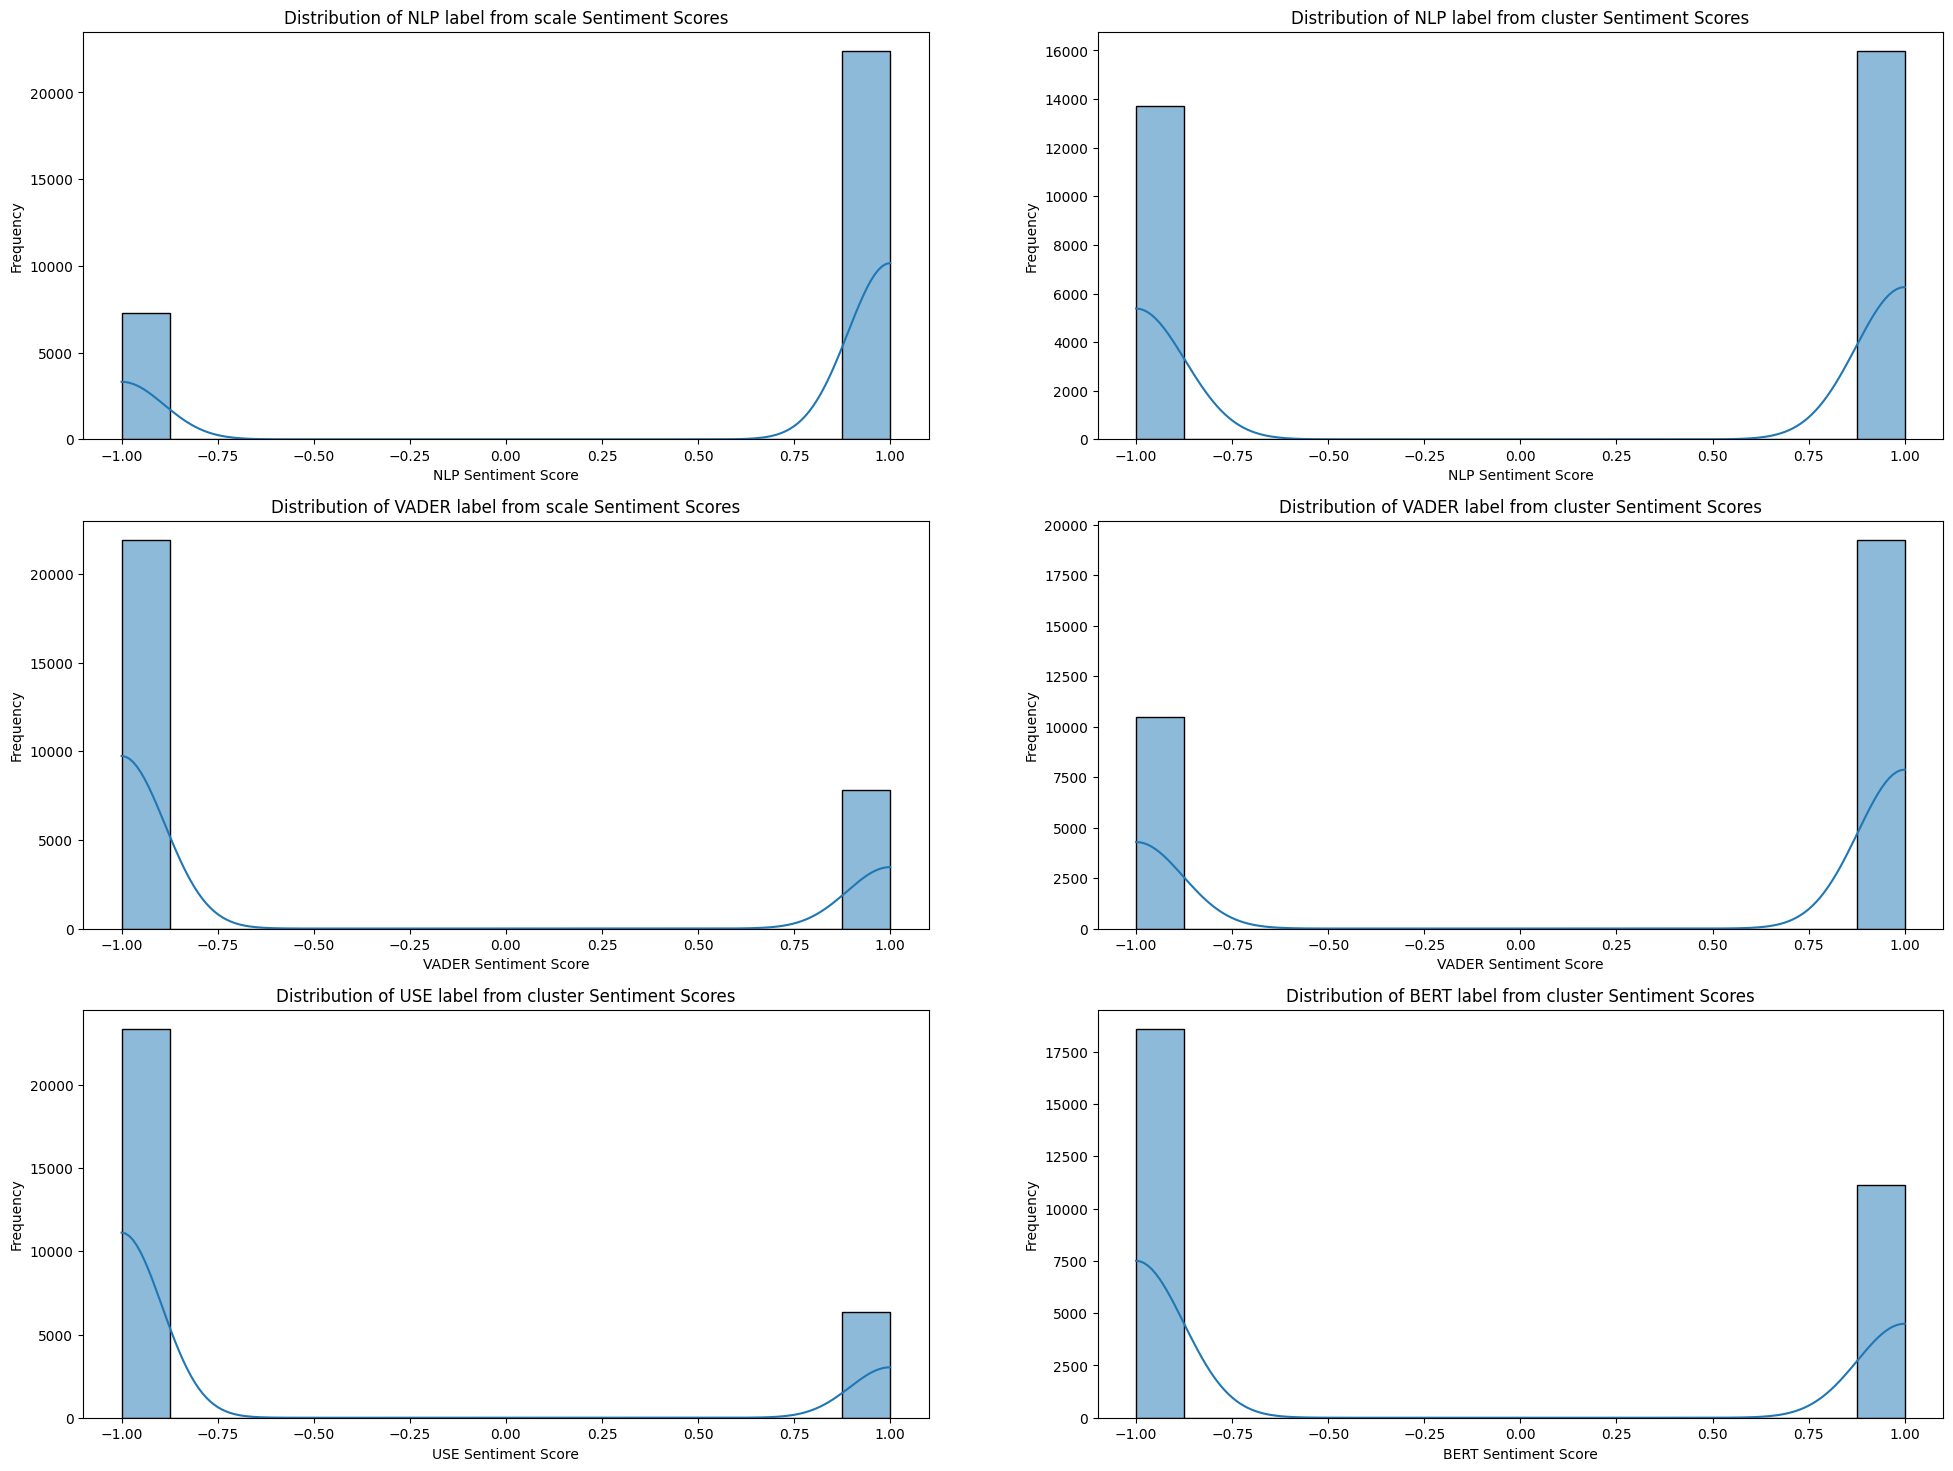

In [116]:
fig, axes = plt.subplots(3, 2, figsize=(24, 18))  # 1 row, 2 columns

# Plot 1: NLP Sentiment Scores
sns.histplot(nlp_scores['nlp_label_from_scale'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of NLP label from scale Sentiment Scores')
axes[0, 0].set_xlabel('NLP Sentiment Score')
axes[0, 0].set_ylabel('Frequency')

# Plot 2: NLP Sentiment Scores (from cluster)
sns.histplot(nlp_scores['nlp_label_from_cluster'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of NLP label from cluster Sentiment Scores')
axes[0, 1].set_xlabel('NLP Sentiment Score')
axes[0, 1].set_ylabel('Frequency')

# Plot 3: VADER Sentiment Scores (from scale)
sns.histplot(nlp_scores['vader_label_from_scale'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of VADER label from scale Sentiment Scores')
axes[1, 0].set_xlabel('VADER Sentiment Score')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: VADER Sentiment Scores (from cluster)
sns.histplot(nlp_scores['vader_label_from_cluster'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of VADER label from cluster Sentiment Scores')
axes[1, 1].set_xlabel('VADER Sentiment Score')
axes[1, 1].set_ylabel('Frequency')

# Plot 5: USE Sentiment Scores (from cluster)
sns.histplot(nlp_scores['use_label_from_cluster'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of USE label from cluster Sentiment Scores')
axes[2, 0].set_xlabel('USE Sentiment Score')
axes[2, 0].set_ylabel('Frequency')

# Plot 6: BERT Sentiment Scores (from cluster)
sns.histplot(nlp_scores['bert_label_from_cluster'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of BERT label from cluster Sentiment Scores')
axes[2, 1].set_xlabel('BERT Sentiment Score')
axes[2, 1].set_ylabel('Frequency')

plt.show()

Creating a grid of histograms to visualize the distributions of daily sentiment scores obtained from different methods (NLP, VADER, USE, BERT). Each subplot shows the distribution of sentiment scores for a particular method, with the x-axis representing the sentiment score and the y-axis representing the frequency.

---

In [117]:
nlp_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29690 entries, 0 to 29689
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      29690 non-null  object 
 1   nlp                       29690 non-null  float64
 2   nlp_label_from_scale      29690 non-null  int64  
 3   vader                     29690 non-null  float64
 4   vader_label_from_scale    29690 non-null  int64  
 5   use_label_from_cluster    29690 non-null  int32  
 6   bert_label_from_cluster   29690 non-null  int32  
 7   nlp_label_from_cluster    29690 non-null  int32  
 8   vader_label_from_cluster  29690 non-null  int32  
dtypes: float64(2), int32(4), int64(2), object(1)
memory usage: 1.6+ MB


We can see how the nlp and vader are in a float dtype and the rest (except for the date col) are integers, and thats because the vader and the nlp are the sentiments and the rest are the labels we assigned.

BERT and USE have no sentiment because their labels are created based on embeddings and not sentiments.

---

Grouping the nlp_scores DataFrame by date and aggregates the sentiment scores using the sum function because the labels are [-1,1] which are the opposites to each other.

In [118]:
nlp_scores = nlp_scores.groupby('date').agg({
    'nlp_label_from_scale': 'sum',
    'vader_label_from_scale': 'sum',
    'nlp_label_from_cluster': 'sum',
    'vader_label_from_cluster': 'sum',
    'use_label_from_cluster': 'sum',
    'bert_label_from_cluster': 'sum'
}).reset_index()
nlp_scores.head(2)

,date,nlp_label_from_scale,vader_label_from_scale,nlp_label_from_cluster,vader_label_from_cluster,use_label_from_cluster,bert_label_from_cluster
0,2023-01-01,12,2,-14,22,-16,2
1,2023-01-02,7,-13,-3,5,-7,-1


In [119]:
nlp_scores.describe()

,nlp_label_from_scale,vader_label_from_scale,nlp_label_from_cluster,vader_label_from_cluster,use_label_from_cluster,bert_label_from_cluster
count,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000
mean,21.723343,-20.317003,3.247839,12.625360,-24.452450,-10.717579
std,10.027875,8.351431,10.537323,7.749747,9.223373,8.940290
min,-4.000000,-47.000000,-25.000000,-14.000000,-56.000000,-36.000000
25%,15.000000,-26.000000,-4.000000,8.000000,-30.000000,-17.000000
50%,21.000000,-20.000000,2.000000,12.000000,-25.000000,-11.000000
75%,28.000000,-15.000000,11.000000,18.000000,-19.000000,-4.250000
max,56.000000,2.000000,36.000000,42.000000,1.000000,19.000000


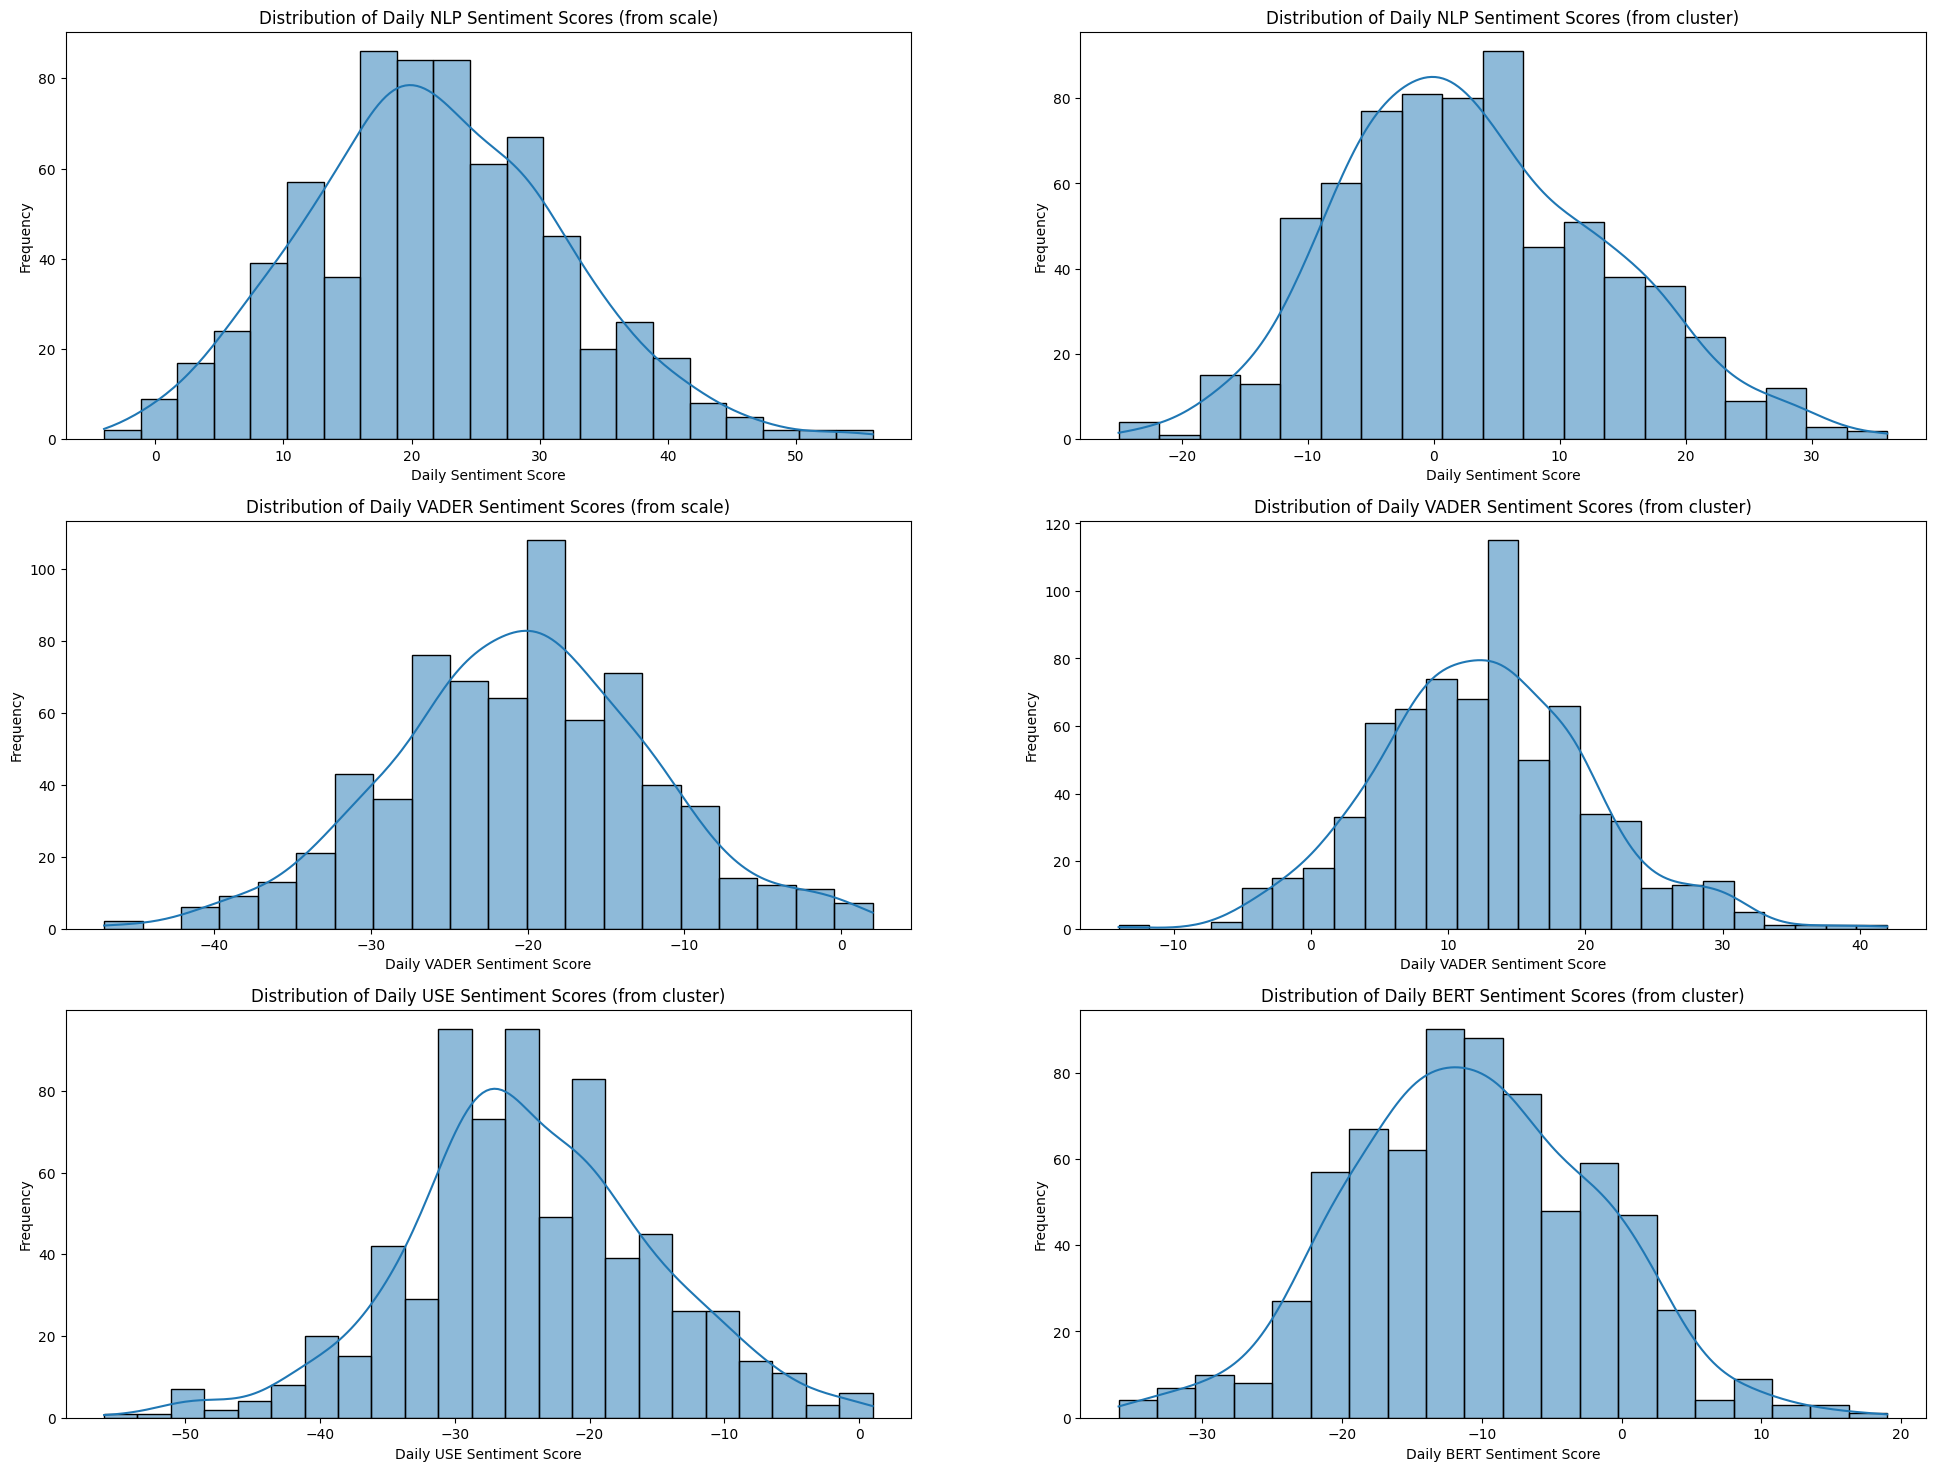

In [120]:
fig, axes = plt.subplots(3, 2, figsize=(24, 18))  # 3 rows, 2 columns

# Plot 1: NLP Sentiment Scores (from scale)
sns.histplot(nlp_scores['nlp_label_from_scale'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Daily NLP Sentiment Scores (from scale)')
axes[0, 0].set_xlabel('Daily Sentiment Score')
axes[0, 0].set_ylabel('Frequency')

# Plot 2: NLP Sentiment Scores (from cluster)
sns.histplot(nlp_scores['nlp_label_from_cluster'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Daily NLP Sentiment Scores (from cluster)')
axes[0, 1].set_xlabel('Daily Sentiment Score')
axes[0, 1].set_ylabel('Frequency')

# Plot 3: VADER Sentiment Scores (from scale)
sns.histplot(nlp_scores['vader_label_from_scale'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Daily VADER Sentiment Scores (from scale)')
axes[1, 0].set_xlabel('Daily VADER Sentiment Score')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: VADER Sentiment Scores (from cluster)
sns.histplot(nlp_scores['vader_label_from_cluster'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Daily VADER Sentiment Scores (from cluster)')
axes[1, 1].set_xlabel('Daily VADER Sentiment Score')
axes[1, 1].set_ylabel('Frequency')

# Plot 5: USE Sentiment Scores (from cluster)
sns.histplot(nlp_scores['use_label_from_cluster'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Daily USE Sentiment Scores (from cluster)')
axes[2, 0].set_xlabel('Daily USE Sentiment Score')
axes[2, 0].set_ylabel('Frequency')

# Plot 6: BERT Sentiment Scores (from cluster)
sns.histplot(nlp_scores['bert_label_from_cluster'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Daily BERT Sentiment Scores (from cluster)')
axes[2, 1].set_xlabel('Daily BERT Sentiment Score')
axes[2, 1].set_ylabel('Frequency')

plt.show()

Those are histograms to visualize the distributions of daily sentiment scores obtained from different methods (NLP, VADER, USE, BERT) after grouping and aggregation.

We can see how, as expected, those distributions are distributed normally. And that might be because we used sum to calculate the daily sentiment score, and based on the Central Limit Theorem (CLT), the sum (or avarage) of independant and identically distrubuted random variables, will tend toward a normal distribution. (regardless of their original distribution).

In the context of sentiment analysis:
1.   Daily Sentiment Scores: The daily sentiment scores are essentially the sum or average of individual sentiment scores for multiple news articles published on that day.
2.   Independence: While news articles might have some correlation, they can be considered relatively independent in terms of their sentiment.
3.   Identical Distribution: The sentiment scores from a specific method (NLP, VADER, etc.) can be assumed to have a similar underlying distribution, even though individual scores might vary.
4.   Large Number of Articles: Typically, a large number of news articles are published daily, contributing to the daily sentiment score.

Therefore, as the daily sentiment score is calculated by aggregating individual sentiment scores from multiple news articles, the CLT comes into play.

---

In [121]:
# Merging stock_data and nlp_scores based on date
data = pd.merge(stock_data, nlp_scores, left_on='Date', right_on='date', how='inner').drop('Date', axis=1).set_index('date')
data.head(2)

,Close,High,Low,Open,Volume,change,shift_label,nlp_label_from_scale,vader_label_from_scale,nlp_label_from_cluster,vader_label_from_cluster,use_label_from_cluster,bert_label_from_cluster
date,,,,,,,,,,,,,
2023-01-04,3852.969971,3873.159912,3815.770020,3840.360107,4414080000,-28.830078,-1,22,-10,-2,14,-20,-10
2023-01-05,3808.100098,3839.739990,3802.419922,3839.739990,3893450000,44.869873,1,13,-11,3,15,-13,-5


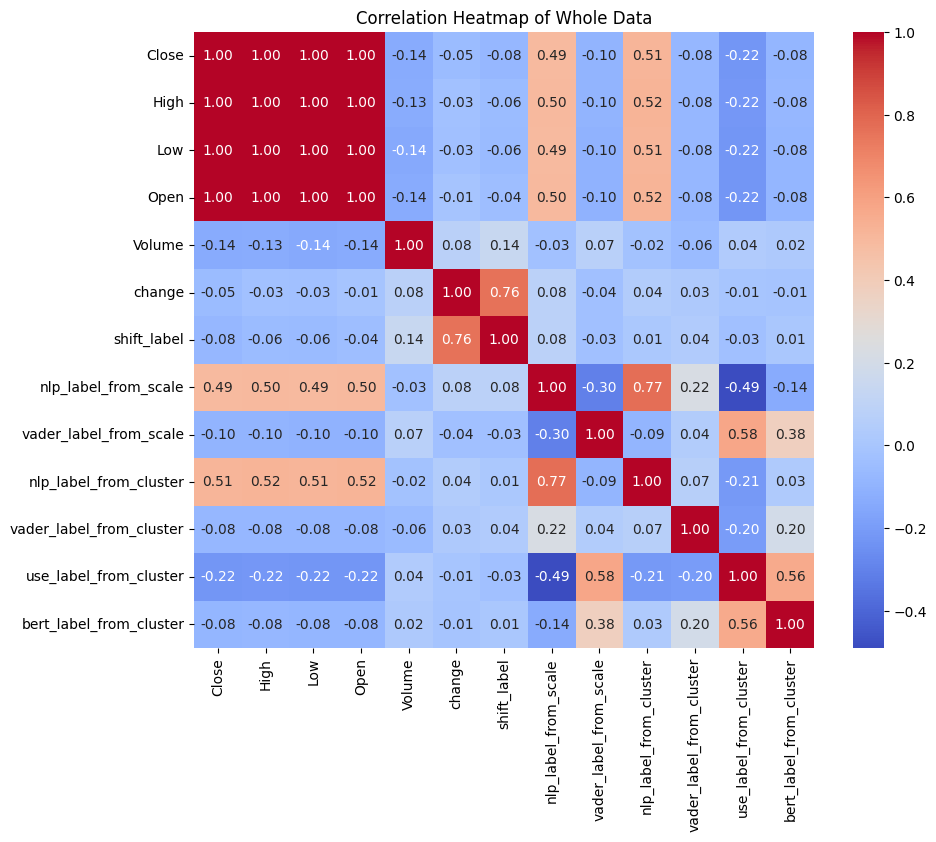

In [122]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Whole Data')
plt.show()

We can see how after all that, the only labels with some type of correlations to the stock prices are the labels from nlp scales, the labels from nlp clusters and the labels from use clusters.
So we'll continue our research with them!

---

In [123]:
features_combinations = [
    ['Open', 'High', 'Low', 'Close', 'Volume', 'nlp_label_from_scale'],
    ['Open', 'High', 'Low', 'Close', 'Volume', 'nlp_label_from_cluster'],
    ['Open', 'High', 'Low', 'Close', 'Volume', 'use_label_from_cluster']
]
y = data['shift_label']

It's important we wont change the original hyper-parameters so we'll be able to compare between the results.

In [124]:
lr = LogisticRegression(C=10, penalty='l1', solver='liblinear')
for features in features_combinations:
    X = data[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f"{features}\nAccuracy:", accuracy_score(y_test, y_pred))
    print(f"F1-Score:", f1_score(y_test, y_pred, average='macro'))
    print()

['Open', 'High', 'Low', 'Close', 'Volume', 'nlp_label_from_scale']
Accuracy: 0.8541666666666666
F1-Score: 0.8518518518518519

['Open', 'High', 'Low', 'Close', 'Volume', 'nlp_label_from_cluster']
Accuracy: 0.84375
F1-Score: 0.8408312147673263

['Open', 'High', 'Low', 'Close', 'Volume', 'use_label_from_cluster']
Accuracy: 0.8541666666666666
F1-Score: 0.8509977827050997



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The same idea of the Sliding Window technique but now with 2 features.

In [125]:
def create_dataset_with_2_fetures(feture1, feture2, window_size=60):
    X, y = [], []
    for i in range(window_size, len(feture1)):
        X.append(np.column_stack((feture1[i-window_size:i], feture2[i-window_size:i])))  # Stack close price and sentiment
        y.append(feture1[i])  # Still predicting the next day's close price
    return np.array(X), np.array(y)

In [126]:
# A sparkle of scaling ✨
close_prices = data['Close'].values.reshape(-1, 1)
scaler_ts = StandardScaler()
scaled_close = scaler_ts.fit_transform(close_prices)

nlp_scores = data['nlp_label_from_scale'].values.reshape(-1, 1)
nlp_cluster_scores = data['nlp_label_from_cluster'].values.reshape(-1, 1)
use_sentiment_scores = data['use_label_from_cluster'].values.reshape(-1, 1)

In [127]:
window_size = 60
X_nlp_ts, y_nlp_ts = create_dataset_with_2_fetures(scaled_close, nlp_scores, window_size)
X_nlp_cluster_ts, y_nlp_cluster_ts = create_dataset_with_2_fetures(scaled_close, nlp_cluster_scores, window_size)
X_use_ts, y_use_ts = create_dataset_with_2_fetures(scaled_close, use_sentiment_scores, window_size)

In [128]:
X_nlp_ts.shape, X_nlp_cluster_ts.shape, X_use_ts.shape # Just for validation..

((416, 60, 2), (416, 60, 2), (416, 60, 2))

In [129]:
# The usual split..
X_nlp_ts_train, X_nlp_ts_test, y_nlp_ts_train, y_nlp_ts_test = train_test_split(X_nlp_ts, y_nlp_ts, test_size=0.2, random_state=42)
X_nlp_cluster_ts_train, X_nlp_cluster_ts_test, y_nlp_cluster_ts_train, y_nlp_cluster_ts_test = train_test_split(X_nlp_cluster_ts, y_nlp_cluster_ts, test_size=0.2, random_state=42)
X_use_ts_train, X_use_ts_test, y_use_ts_train, y_use_ts_test = train_test_split(X_use_ts, y_use_ts, test_size=0.2, random_state=42)

In [130]:
# Replacing NaN values with 0 to avoid any problems with the fitting.
X_nlp_ts_train, X_nlp_ts_test = np.nan_to_num(X_nlp_ts_train), np.nan_to_num(X_nlp_ts_test)
y_nlp_ts_train, y_nlp_ts_test = np.nan_to_num(y_nlp_ts_train), np.nan_to_num(y_nlp_ts_test)

X_nlp_cluster_ts_train, X_nlp_cluster_ts_test = np.nan_to_num(X_nlp_cluster_ts_train), np.nan_to_num(X_nlp_cluster_ts_test)
y_nlp_cluster_ts_train, y_nlp_cluster_ts_test = np.nan_to_num(y_nlp_cluster_ts_train), np.nan_to_num(y_nlp_cluster_ts_test)

X_use_ts_train, X_use_ts_test = np.nan_to_num(X_use_ts_train), np.nan_to_num(X_use_ts_test)
y_use_ts_train, y_use_ts_test = np.nan_to_num(y_use_ts_train), np.nan_to_num(y_use_ts_test)

In [131]:
# Same time series model for comparison.
model_ts_with_sentiments = Sequential([
    Bidirectional(LSTM(50, return_sequences=True)),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(25, 'relu'),
    Dense(1)
])

In [132]:
datasets = {'nlp_ts':(X_nlp_ts_train, X_nlp_ts_test, y_nlp_ts_train, y_nlp_ts_test),
            'nlp_clusters_ts':(X_nlp_cluster_ts_train, X_nlp_cluster_ts_test, y_nlp_cluster_ts_train, y_nlp_cluster_ts_test),
            'use_ts':(X_use_ts_train, X_use_ts_test, y_use_ts_train, y_use_ts_test)}

In [ ]:
for name, (X_ts_train, X_ts_test, y_ts_train, y_ts_test) in datasets.items():
    model_ts_with_sentiments.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    # Training the model and storing the training history
    history = model_ts_with_sentiments.fit(
        X_ts_train, y_ts_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_ts_test, y_ts_test),
        callbacks=callbacks_list
    )
    # Store the training history with the dataset name
    globals()[f'{name}_history'] = history

In [134]:
print(f"Lowest Validation Loss without sentiments: {lowest_val_loss} which is approximately {lowest_close_price}")

lowest_nlp_val_loss_sentiment = min(nlp_ts_history.history['val_loss'])
lowest_nlp_close_price = np.sqrt(scaler_ts.inverse_transform([[lowest_nlp_val_loss_sentiment]])[0][0])
print(f"Lowest NLP Validation Loss: {lowest_nlp_val_loss_sentiment} which is approximately {lowest_nlp_close_price}")

lowest_nlp_clusters_val_loss_sentiment = min(nlp_clusters_ts_history.history['val_loss'])
lowest_nlp_clusters_close_price = np.sqrt(scaler_ts.inverse_transform([[lowest_nlp_clusters_val_loss_sentiment]])[0][0])
print(f"Lowest NLP Clusters Validation Loss: {lowest_nlp_clusters_val_loss_sentiment} which is approximately {lowest_nlp_clusters_close_price}")

lowest_use_val_loss_sentiment = min(use_ts_history.history['val_loss'])
lowest_use_close_price = np.sqrt(scaler_ts.inverse_transform([[lowest_use_val_loss_sentiment]])[0][0])
print(f"Lowest USE Validation Loss: {lowest_use_val_loss_sentiment} which is approximately {lowest_use_close_price}")

Lowest Validation Loss without sentiments: 0.007622861303389072 which is approximately 69.38785462600137
Lowest NLP Validation Loss: 0.010543642565608025 which is approximately 69.4223185287018
Lowest NLP Clusters Validation Loss: 0.008516314439475536 which is approximately 69.41331707181452
Lowest USE Validation Loss: 0.009043563157320023 which is approximately 69.4156581996425
